# Project 2 - Supervised Learning

### Let's first check the data in the **train.csv**

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import time

train_data = pd.read_csv('train.csv')

print(train_data.head())

  policy_id  policy_tenure  age_of_car  age_of_policyholder area_cluster   
0   ID00001       0.515874        0.05             0.644231           C1  \
1   ID00002       0.672619        0.02             0.375000           C2   
2   ID00003       0.841110        0.02             0.384615           C3   
3   ID00004       0.900277        0.11             0.432692           C4   
4   ID00005       0.596403        0.11             0.634615           C5   

   population_density  make segment model fuel_type  ... is_brake_assist   
0                4990     1       A    M1       CNG  ...              No  \
1               27003     1       A    M1       CNG  ...              No   
2                4076     1       A    M1       CNG  ...              No   
3               21622     1      C1    M2    Petrol  ...             Yes   
4               34738     2       A    M3    Petrol  ...              No   

  is_power_door_locks is_central_locking  is_power_steering   
0                  No  

### Let's check if there are columns with missing values
### And change the non-numeric columns to numeric

In [27]:
cols_with_na = train_data.columns[train_data.isna().any()].tolist()
print('Columns with missing values:', cols_with_na)

train_data['policy_id'] = train_data['policy_id'].apply(lambda x: x.replace('ID', ''))
train_data['area_cluster'] = train_data['area_cluster'].apply(lambda x: x.replace('C', ''))
train_data = pd.get_dummies(train_data, columns=['segment', 'fuel_type', 'engine_type', 'rear_brakes_type', 'steering_type'])
train_data['model'] = train_data['model'].apply(lambda x: x.replace('M', ''))
train_data = train_data.replace({"Yes": True, "No": False})
encoder = LabelEncoder()
train_data['transmission_type'] = encoder.fit_transform(train_data['transmission_type'])

train_data['max_torque'] = train_data['max_torque'].apply(lambda s: float(s.split('Nm@')[0]) * float(s.split('Nm@')[1].replace('rpm', '')))
train_data['max_power'] = train_data['max_power'].apply(lambda s: float(s.split('bhp@')[0]) * float(s.split('bhp@')[1].replace('rpm', '')))


Columns with missing values: []


As we can see, there are no missing values in our data set

### Let's now get some more general information of our features

In [28]:
print(train_data.describe())

       policy_tenure    age_of_car  age_of_policyholder  population_density   
count   58592.000000  58592.000000         58592.000000        58592.000000  \
mean        0.611246      0.069424             0.469420        18826.858667   
std         0.414156      0.056721             0.122886        17660.174792   
min         0.002735      0.000000             0.288462          290.000000   
25%         0.210250      0.020000             0.365385         6112.000000   
50%         0.573792      0.060000             0.451923         8794.000000   
75%         1.039104      0.110000             0.548077        27003.000000   
max         1.396641      1.000000             1.000000        73430.000000   

               make     max_torque      max_power       airbags  displacement   
count  58592.000000   58592.000000   58592.000000  58592.000000  58592.000000  \
mean       1.763722  443082.164289  401744.181356      3.137066   1162.355851   
std        1.136988  182064.141526  116651.11

In [29]:
%matplotlib inline

sb.pairplot(train_data)

<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:200: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_functio

Error in callback <function _draw_all_if_interactive at 0x000001D77FE198A0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001D7218E28E0> (for post_execute):


KeyboardInterrupt: 

After some investigating, there are no major outliers that require work.
There are some variables that seem to have no correlation with the `is_claim` feature

### Now let's check what features have no correlation with the test feature

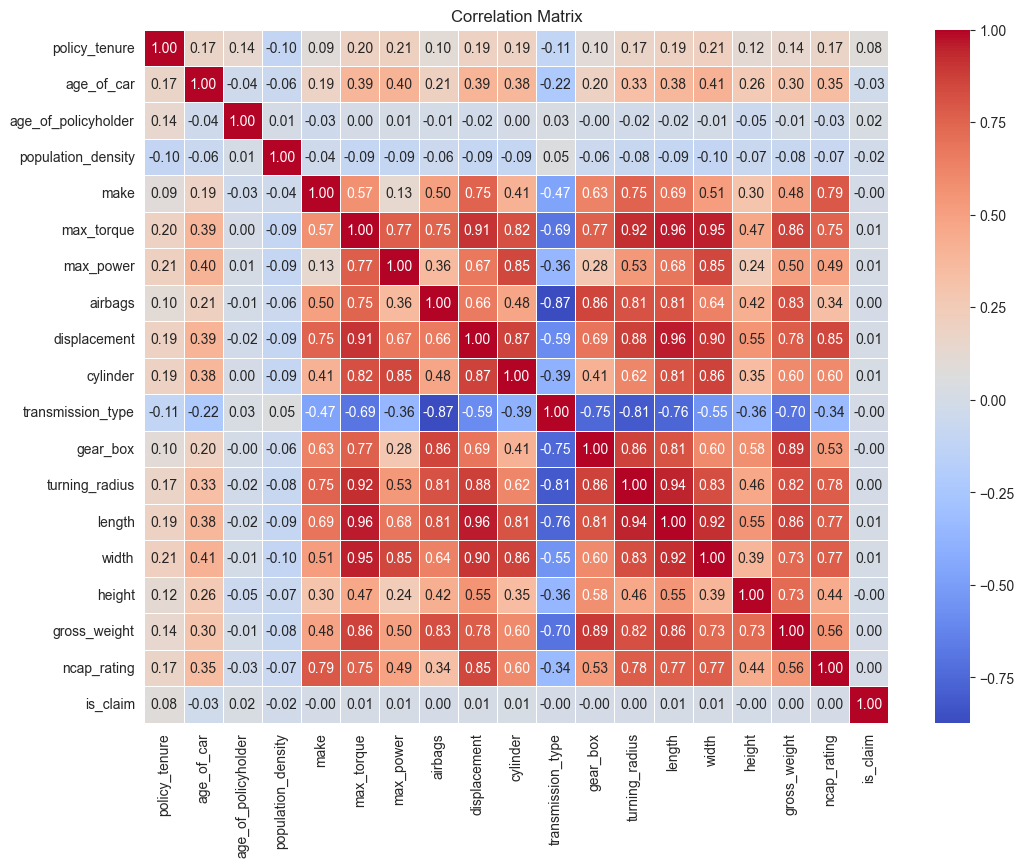

In [30]:

numeric_columns = train_data.select_dtypes(include='number')
train_data_numeric = train_data[numeric_columns.columns]

correlation_matrix = train_data_numeric.corr()

# Creating the subsets without the highly correlated features
corr_cols08 = set()
corr_cols09 = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[j]
            corr_cols08.add(colname)

        if correlation_matrix.columns[i] != correlation_matrix.columns[j] and abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname = correlation_matrix.columns[j]
            corr_cols09.add(colname)


train_data_08 = train_data_numeric.drop(columns=corr_cols08)
train_data_09 = train_data_numeric.drop(columns=corr_cols09)

plt.figure(figsize=(12, 9))
sb.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

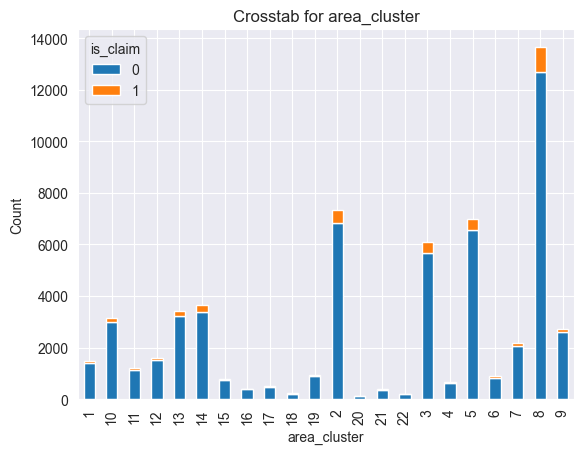

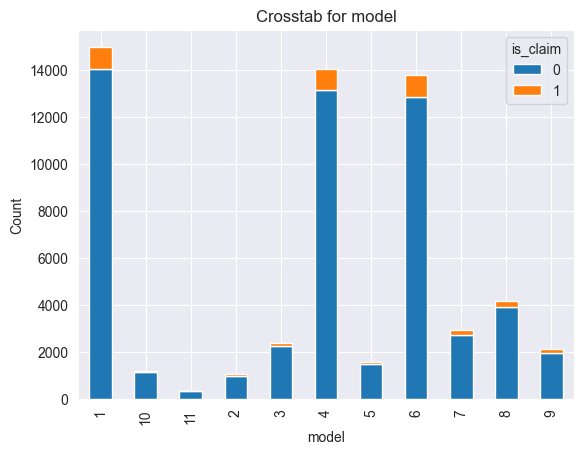

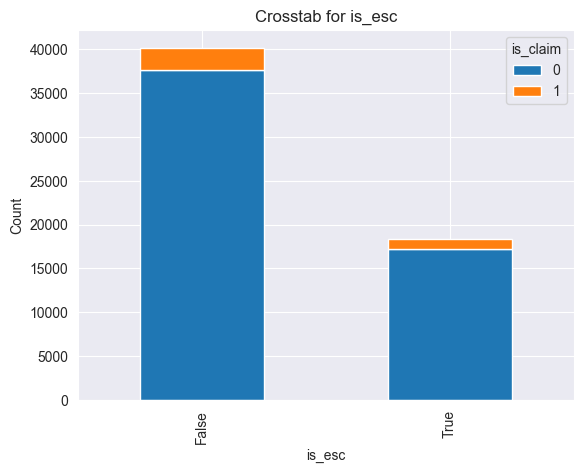

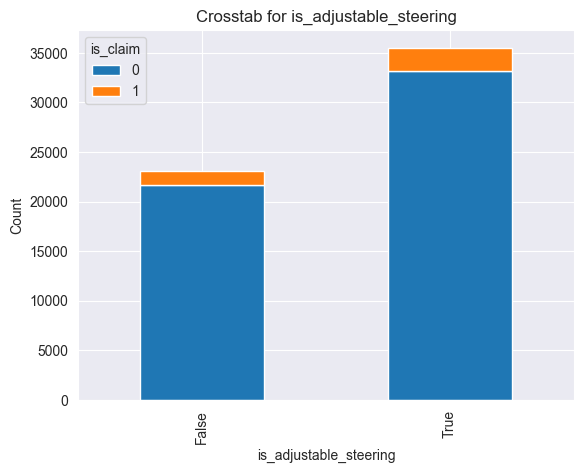

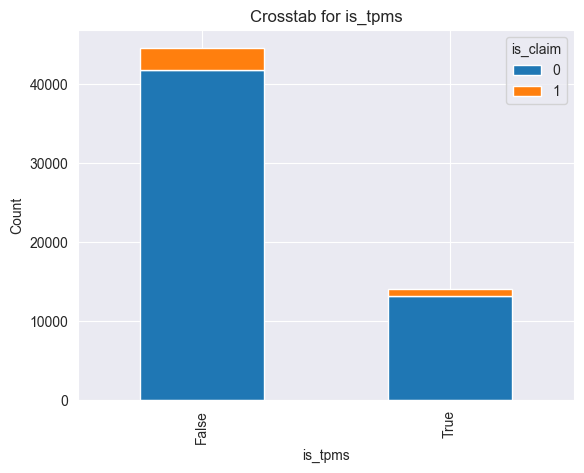

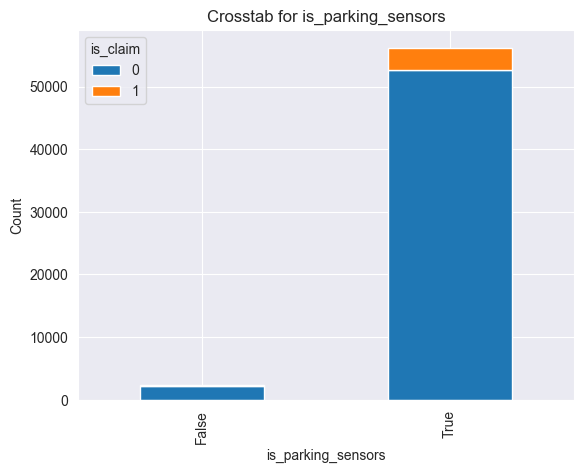

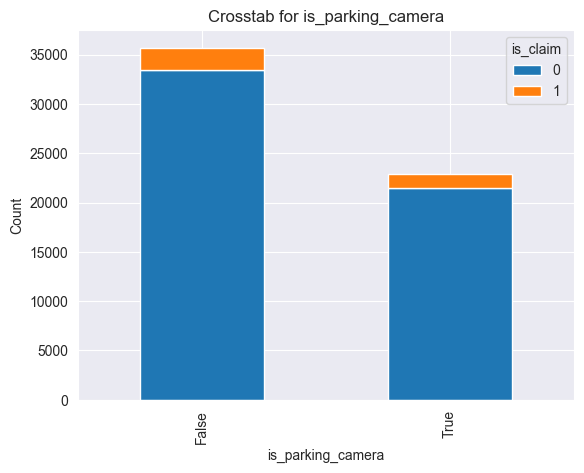

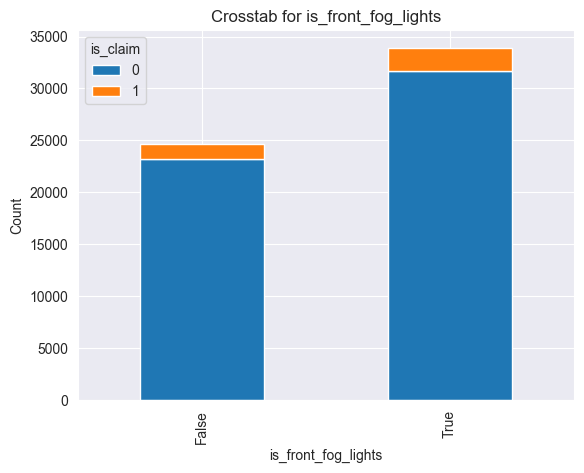

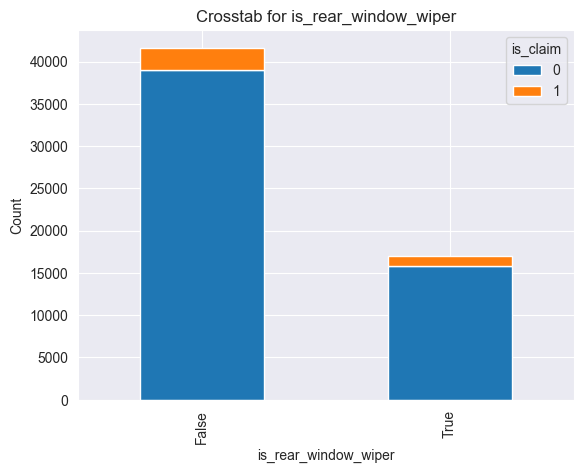

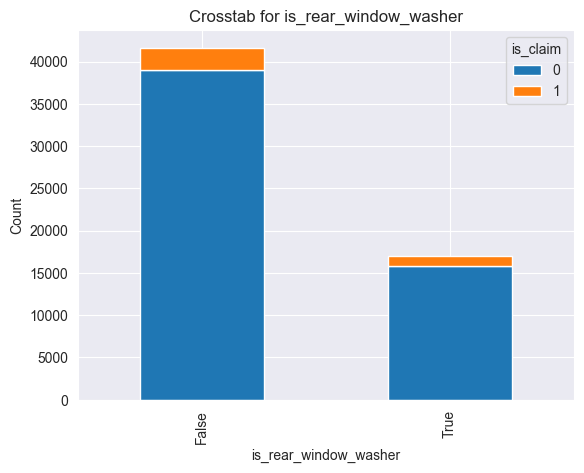

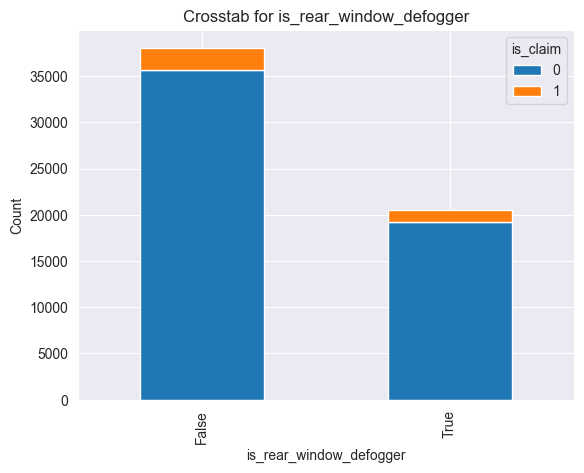

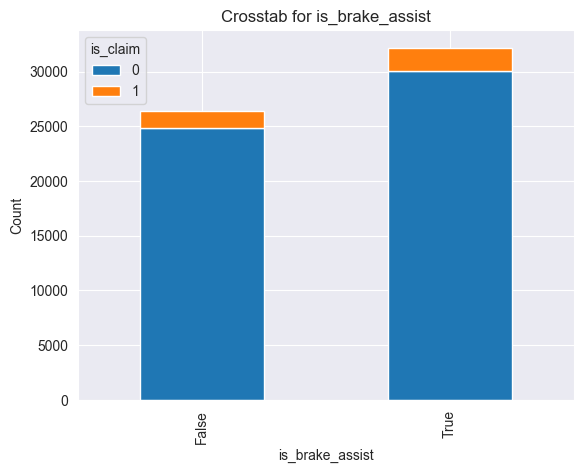

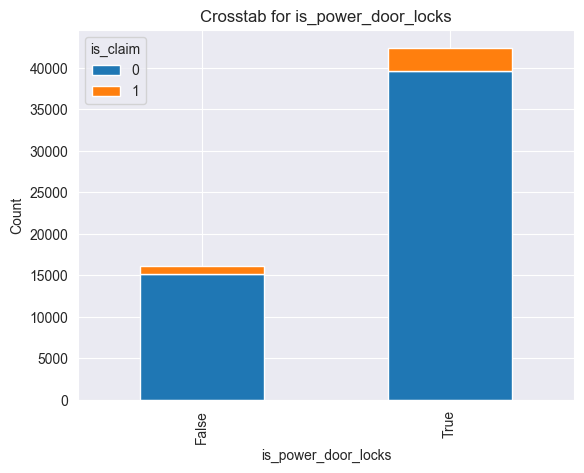

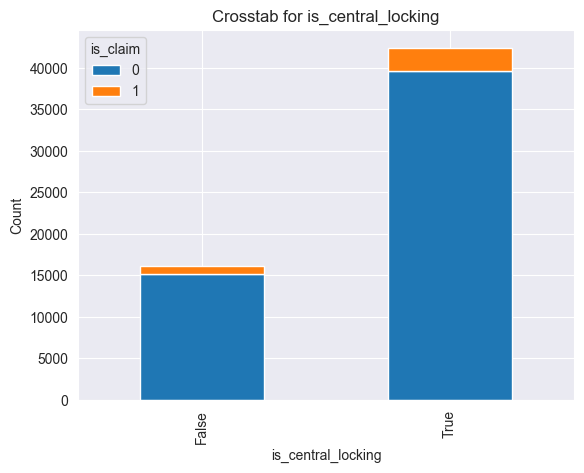

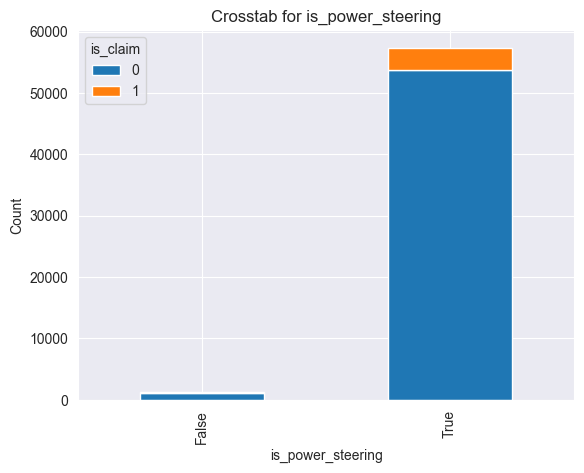

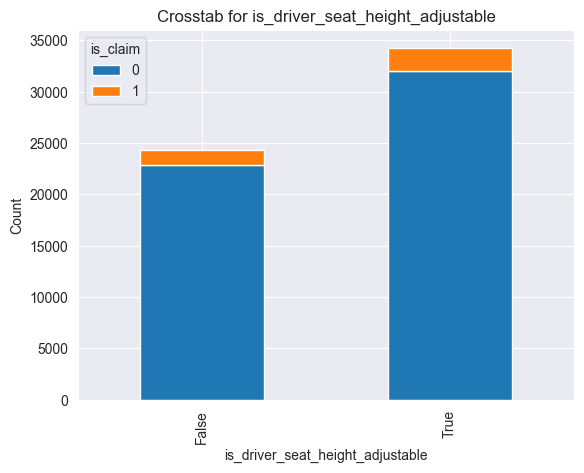

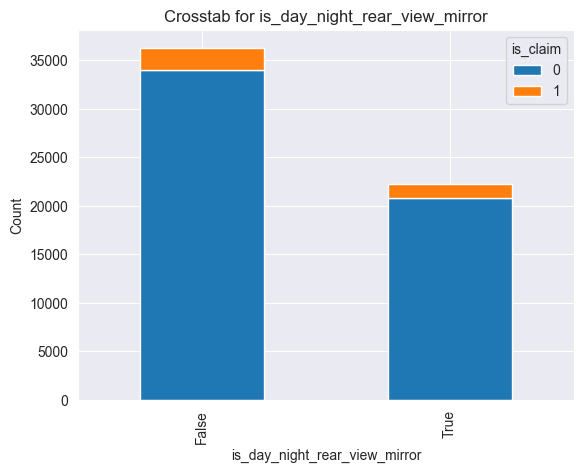

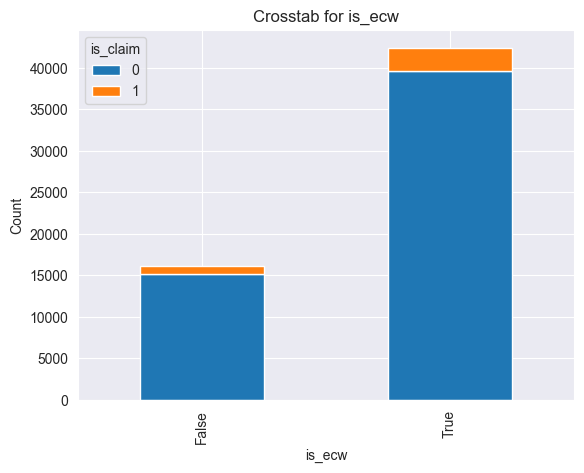

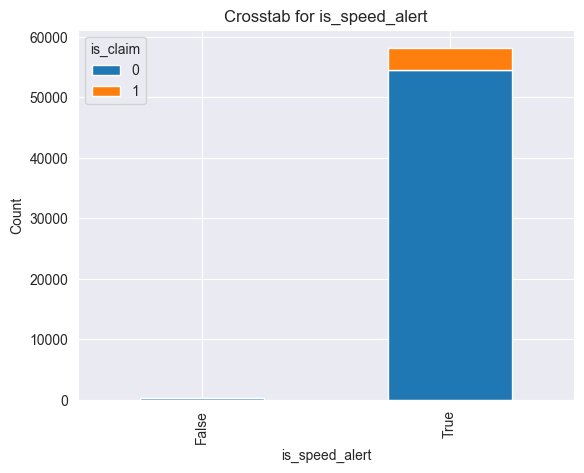

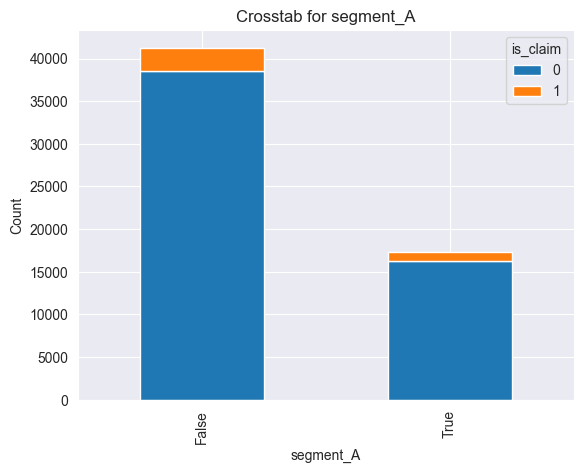

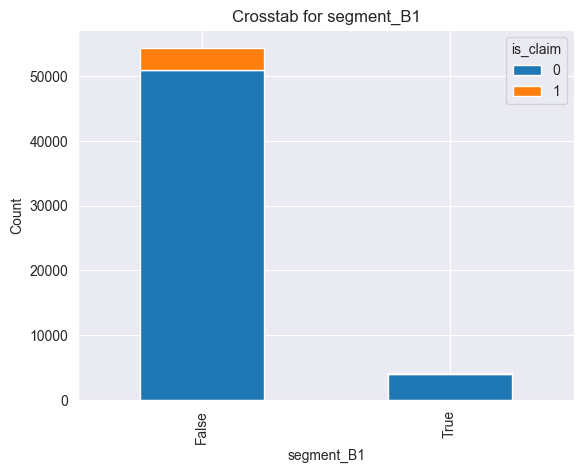

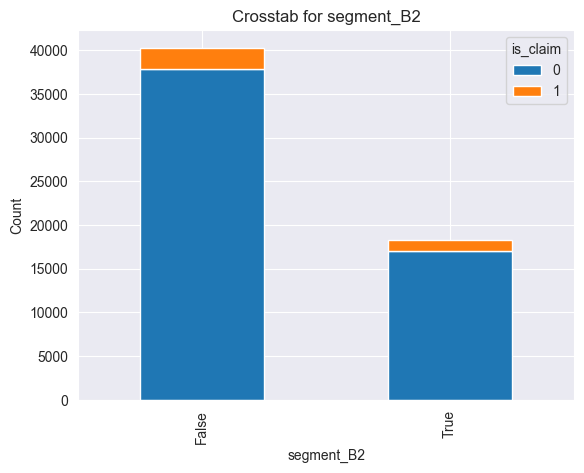

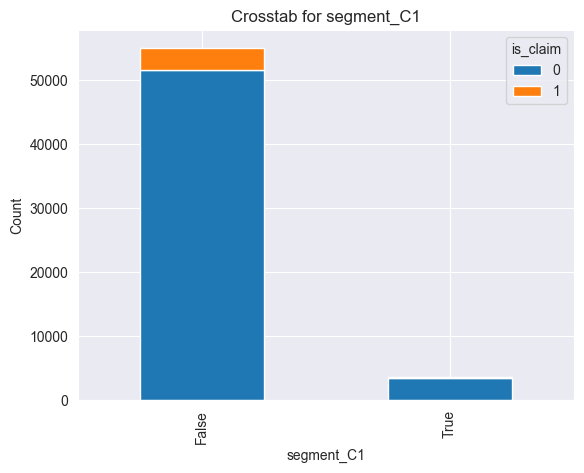

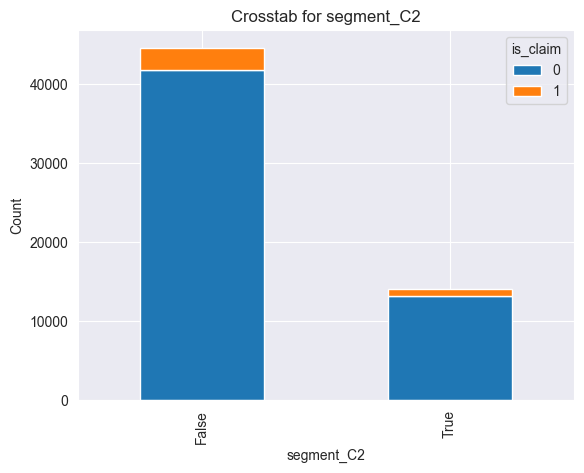

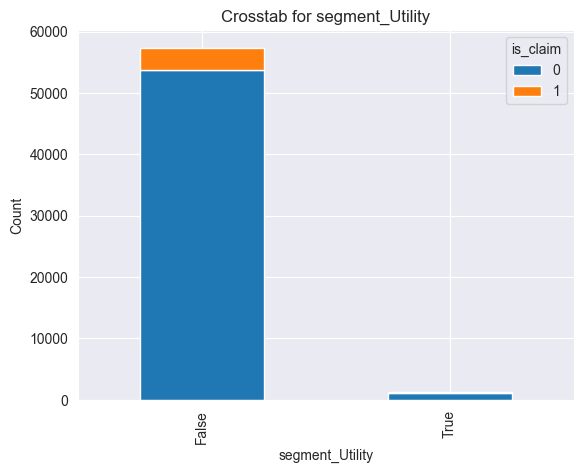

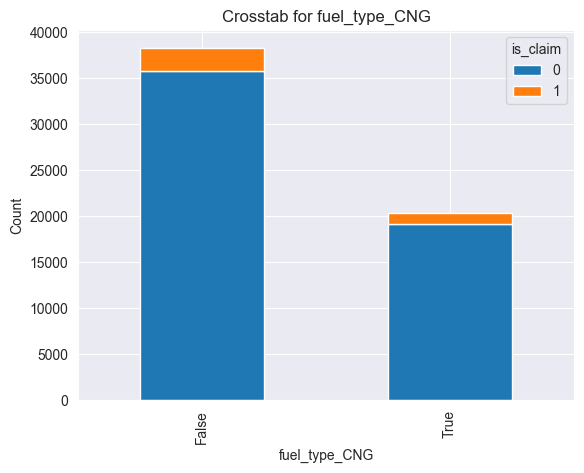

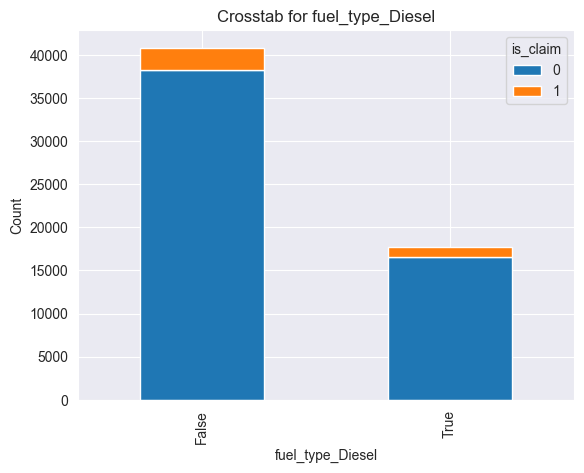

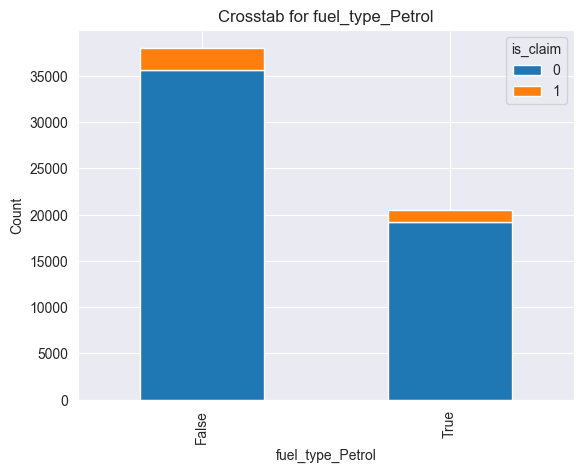

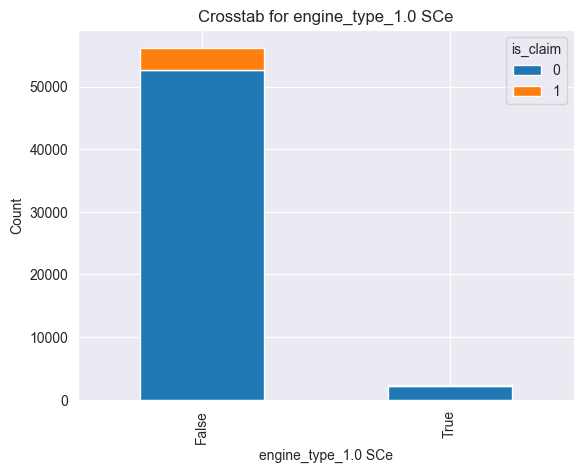

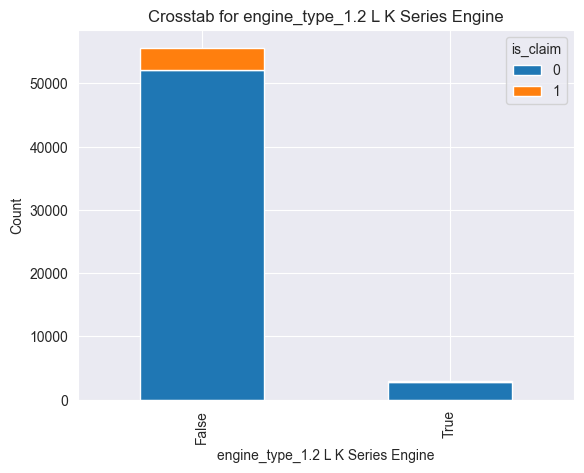

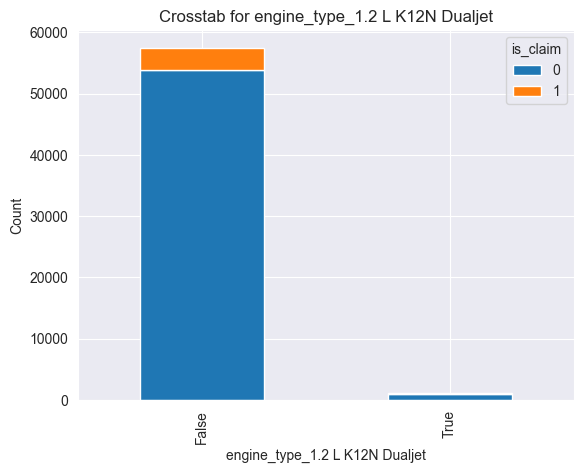

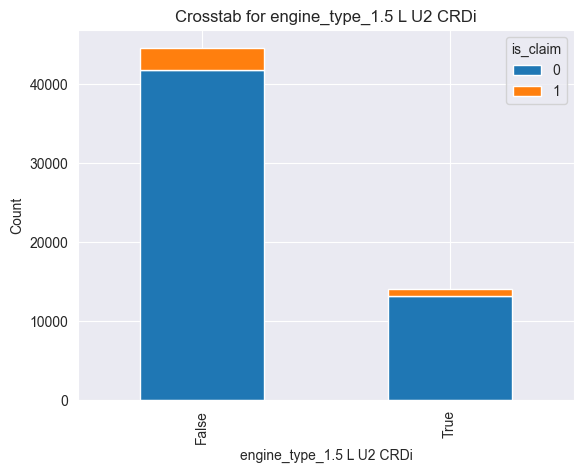

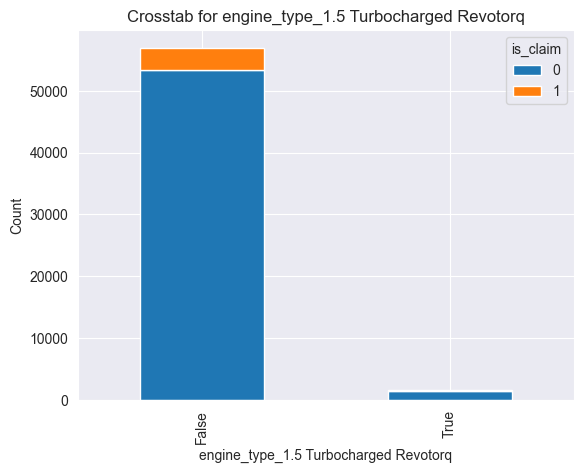

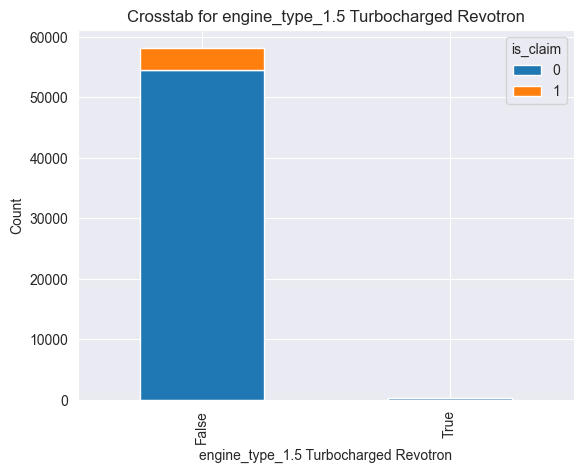

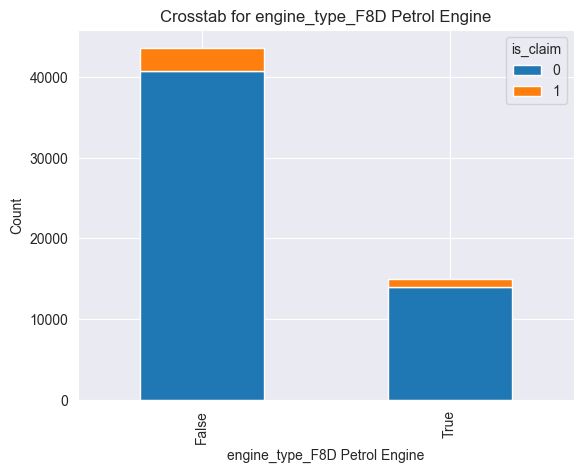

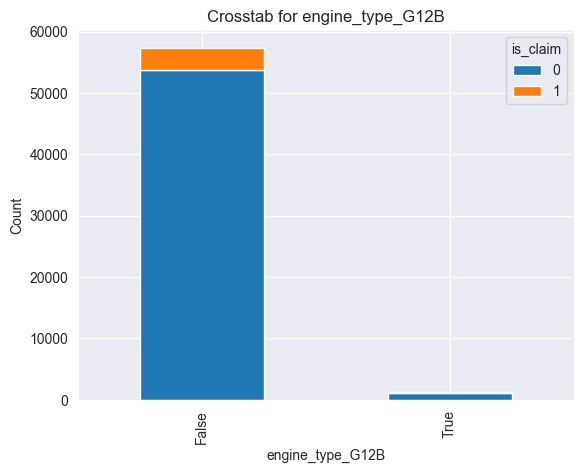

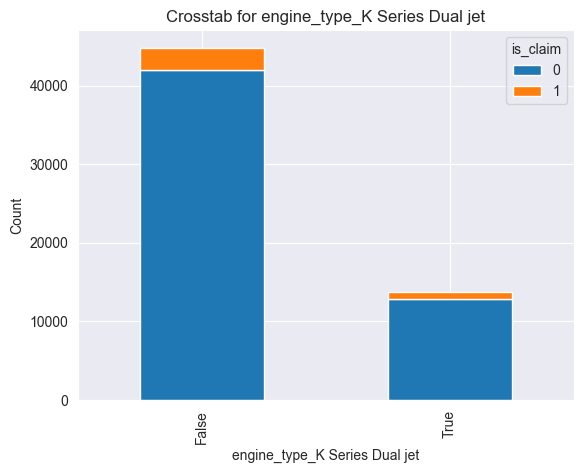

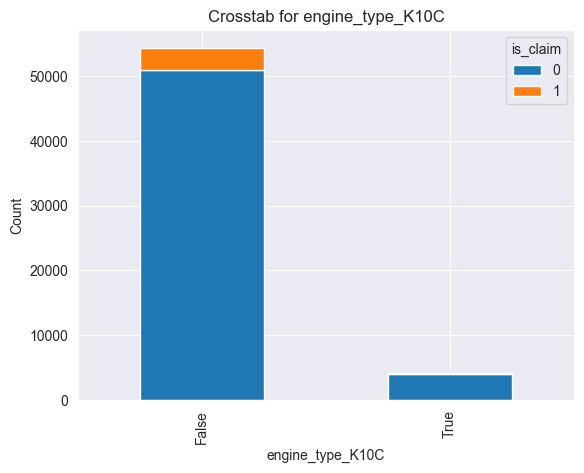

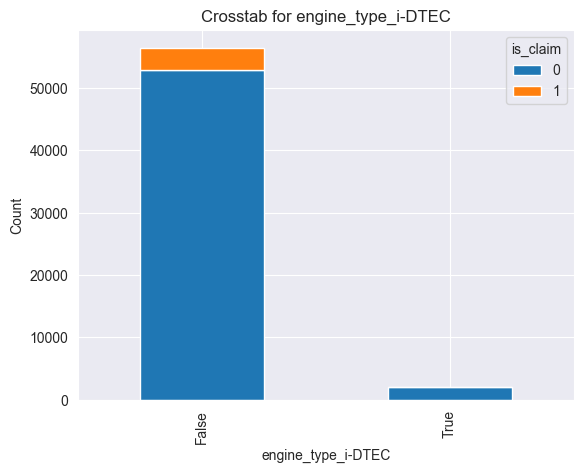

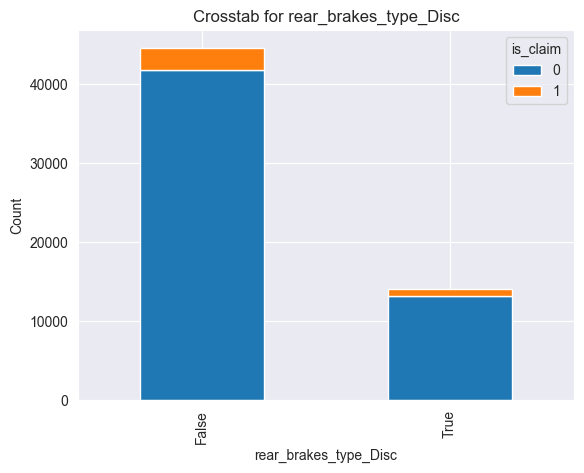

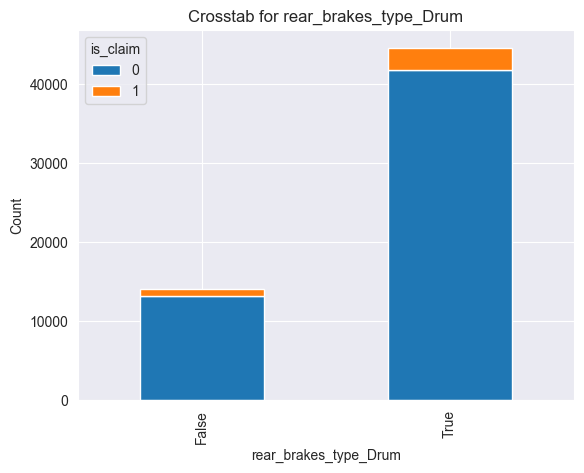

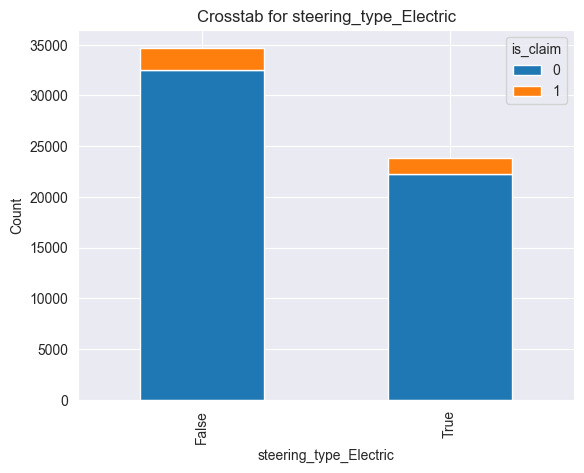

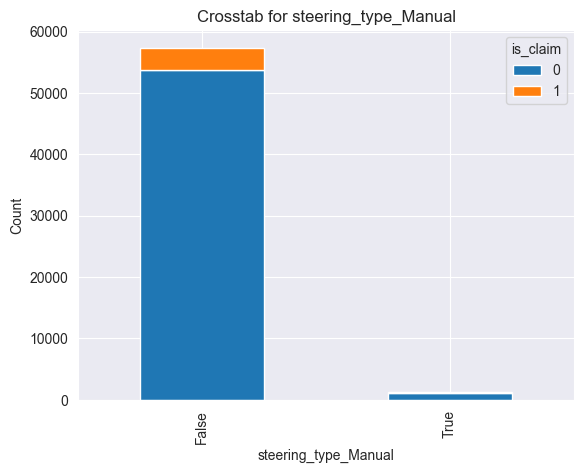

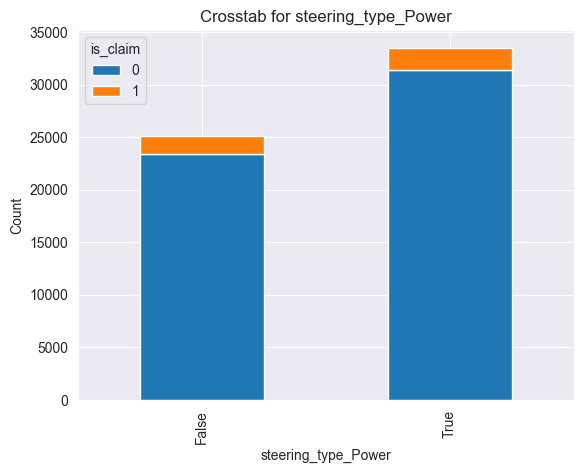

In [31]:
non_numeric_columns = train_data.select_dtypes(exclude='number')

for column in non_numeric_columns:
    if 'id' in column: continue
    crosstab_table = pd.crosstab(train_data[column], train_data['is_claim'])
    crosstab_table.plot(kind='bar', stacked=True)

    plt.title(f'Crosstab for {column}')
    plt.xlabel(column)
    plt.ylabel('Count')

    plt.show()



Numeric features don't correlate with the `is_claim` feature, most probably because it is a binary feature and not a number one.
But there are others features that correlate with each other, which might give more strength to those values, something that we want to avoid.
A good way of avoiding it is to remove the column that correlate too much with another (>= 0.85)

In non-numeric features we didn't get a clear separation but there are some choices that are more favorable. For example in the feature `segment`, people insure more an `A` than a `Utility` value

### Let's now dive into the classifier methods

We have done an initial comparison of all the algorithms

In [32]:
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Neural Network': MLPClassifier(),
    'K-NN': KNeighborsClassifier(),
    'SVM': SVC()
}
target_column = "is_claim"
X = train_data.drop(target_column, axis=1)
y = train_data[target_column]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

('Decision Tree', DecisionTreeClassifier())
('Neural Network', MLPClassifier())
('K-NN', KNeighborsClassifier())
('SVM', SVC())
       Classifier              Confusion Matrix  Precision    Recall   
0   Decision Tree  [[15205, 1212], [1048, 113]]   0.879363  0.871430  \
1  Neural Network       [[16416, 1], [1160, 1]]   0.905336  0.933952   
2            K-NN      [[16374, 43], [1156, 5]]   0.879243  0.931790   
3             SVM       [[16417, 0], [1161, 0]]   0.938314  0.933952   

   Accuracy  F1 Score  Train Time  Test Time  
0  0.871430  0.875348    0.640292   0.022019  
1  0.933952  0.902167   10.908648   0.034030  
2  0.931790  0.901511    0.052047   1.087824  
3  0.933952  0.902055   13.016479   9.465407  


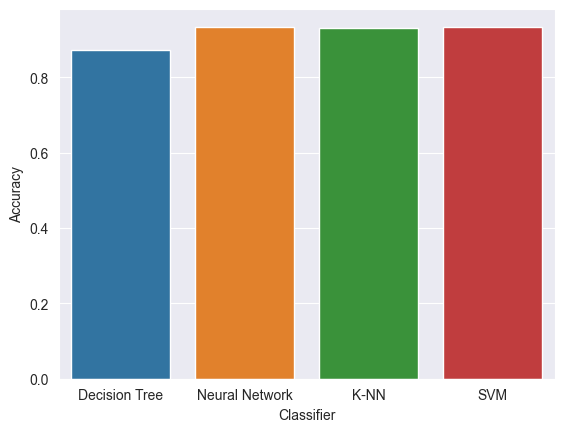

In [33]:
# Train and evaluate the classifiers
results = []

for (name, classifier) in classifiers.items():

    print((name, classifier))
    # Train the model
    start_time = time.time()
    classifier.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Test the model
    start_time = time.time()
    y_pred = classifier.predict(X_test)
    test_time = time.time() - start_time

    # Calculate evaluation metrics
    conf_matrix = confusion_matrix(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Store the results
    results.append({
        'Classifier': name,
        'Confusion Matrix': conf_matrix,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Train Time': train_time,
        'Test Time': test_time
    })
# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)

# Visualize the results (e.g., using Seaborn or Matplotlib)
# Example: Plotting the accuracy of different classifiers
sb.barplot(x='Classifier', y='Accuracy', data=results_df)
plt.show()